## Snapcommerce: Analytics Engineer intern challenge (Option 1: Analytics Case Study)

### Question 1

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('Thank You Call Data - Sheet1.csv')

In [3]:
print(data.shape)
data.head()

(23759, 6)


,USER_ID,CHECK_OUT_MONTH,THANK_YOU_STATUS,LTR,BOOKINGS,GMV
0,10157,2018-09-01,thank_you_call,106.640369,6.0,4926.957
1,10263,2018-03-01,thank_you_call,388.322847,25.0,18481.635
2,10362,2018-01-01,thank_you_call,588.327102,15.0,7010.647
3,10382,2018-11-01,thank_you_call,6.402000,2.0,1144.032
4,10463,2019-01-01,no_call,51.815610,3.0,1271.090


In [4]:
#unique and missing values
print('Unique users: ' + str(data['USER_ID'].nunique()))
print('Unique dates: ' + str(data['CHECK_OUT_MONTH'].nunique()))
print('\nMissing data:\n' + str(data.isnull().sum()))

Unique users: 23759
Unique dates: 26

Missing data:
USER_ID               0
CHECK_OUT_MONTH       0
THANK_YOU_STATUS      0
LTR                 557
BOOKINGS            557
GMV                 557
dtype: int64


In [5]:
#min and max timestamp
df = pd.DataFrame(columns=['dates'])
dates = pd.to_datetime(data.CHECK_OUT_MONTH)
print(dates.min())
print(dates.max())

2017-05-01 00:00:00
2019-06-01 00:00:00


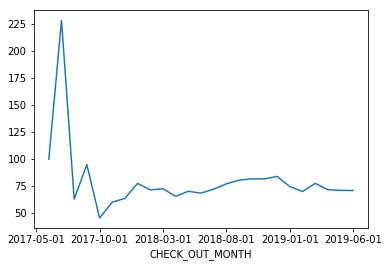

In [6]:
#LTR vs checkout month to check for time invariance
dates['LTR'] = data.groupby('CHECK_OUT_MONTH').mean()['LTR']
dates['LTR'].plot()

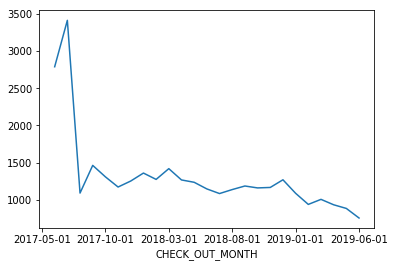

In [7]:
#GMV vs checkout month to check for time invariance
dates['GMV'] = data.groupby('CHECK_OUT_MONTH').mean()['GMV']
dates['GMV'].plot()

In [8]:
#further to quantitatively check if LTR, GMV and BOOKINGS has time invariant

#thank_you_status_yes.groupby('CHECK_OUT_MONTH')['LTR'].aggregate('median').sort_values(ascending=False)
#data.groupby('CHECK_OUT_MONTH')['GMV'].aggregate('median').sort_values(ascending=False)
#data.groupby('CHECK_OUT_MONTH')['BOOKINGS'].aggregate('median').sort_values(ascending=False)

Both LTR and GMV are dependent on check_out_month. This is potentially because customers with later first booking had less time window to make subsequent bookings. 

In [9]:
#filling missing data with median column value of the same month
data['LTR'].fillna(data.groupby('CHECK_OUT_MONTH')['LTR'].transform('median'), inplace=True)
data['GMV'].fillna(data.groupby('CHECK_OUT_MONTH')['GMV'].transform('median'), inplace=True)
data['BOOKINGS'].fillna(data.groupby('CHECK_OUT_MONTH')['BOOKINGS'].transform('median'), inplace=True)
data.dropna(inplace=True)

In [10]:
#Assuming current date is 1st january 2021. Calculate the total days since first booking made for each customer
#then normalize LTR, BOOKINGS and GMV by 30*first_booking_since
import datetime
from datetime import datetime
end_date=datetime(2021,1,1)

data['first_booking_since'] = (end_date-(data['CHECK_OUT_MONTH']).apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))) / np.timedelta64(1, 'D')
data['monthly_LTR'] = (30*data['LTR'])/data['first_booking_since']
data['monthly_BOOKINGS'] = (30*data['BOOKINGS'])/data['first_booking_since']
data['monthly_GMV'] = (30*data['GMV'])/data['first_booking_since']

In [11]:
#splitting data by THANK_YOU_STATUS
thank_you_status_yes = data[data.THANK_YOU_STATUS=='thank_you_call']
thank_you_status_no = data[data.THANK_YOU_STATUS=='no_call']

In [12]:
#shape of the two dataframes
print('Shape:')
print(thank_you_status_yes.shape)
print(thank_you_status_no.shape)

Shape:
(8287, 10)
(15470, 10)


In [13]:
#General comparison between groups
print('Customers who received thank you call:')
print(thank_you_status_yes[['monthly_LTR','monthly_BOOKINGS','monthly_GMV']].mean())
print()
print('Customers who did not receive thank you call:')
print(thank_you_status_no[['monthly_LTR','monthly_BOOKINGS','monthly_GMV']].mean())

Customers who received thank you call:
monthly_LTR          2.646282
monthly_BOOKINGS     0.063569
monthly_GMV         40.520384
dtype: float64

Customers who did not receive thank you call:
monthly_LTR          2.741980
monthly_BOOKINGS     0.072425
monthly_GMV         40.190457
dtype: float64


No obvious difference at general look

### Visual analysis

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


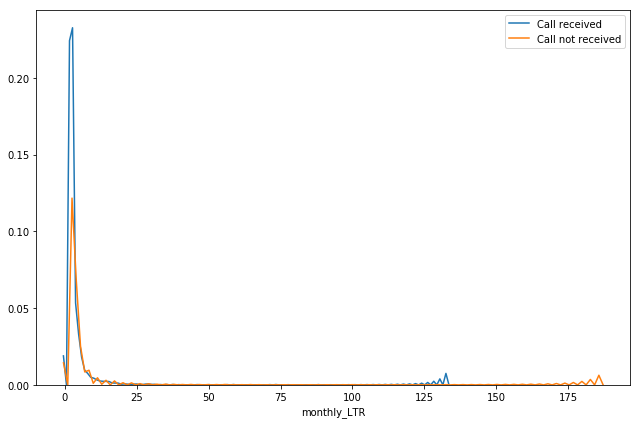

In [14]:
fig, ax = plt.subplots(figsize=(9,6))
sns.distplot(thank_you_status_yes['monthly_LTR'], ax=ax, hist=False, label = 'Call received')
sns.distplot(thank_you_status_no['monthly_LTR'], ax=ax, hist=False, label = 'Call not received')
plt.tight_layout()

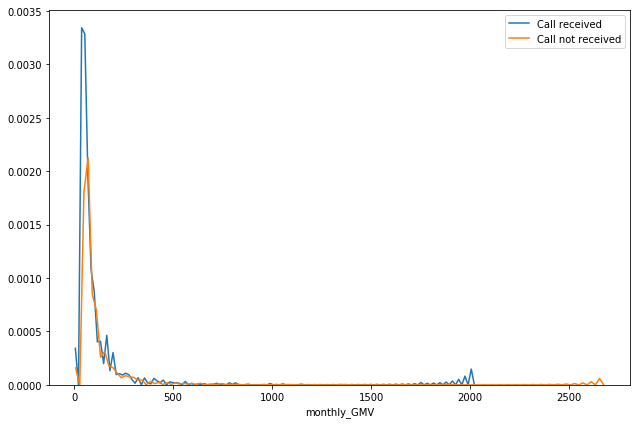

In [15]:
fig, ax = plt.subplots(figsize=(9,6))
sns.distplot(thank_you_status_yes['monthly_GMV'], ax=ax, hist=False, label = 'Call received')
sns.distplot(thank_you_status_no['monthly_GMV'], ax=ax, hist=False, label = 'Call not received')
plt.tight_layout()

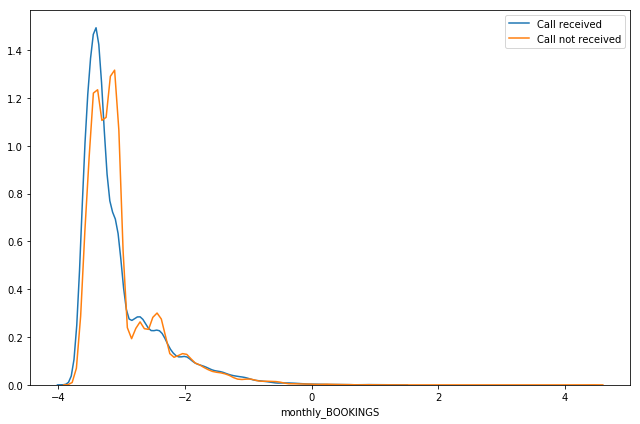

In [16]:
fig, ax = plt.subplots(figsize=(9,6))
sns.distplot(np.log(thank_you_status_yes['monthly_BOOKINGS']), ax=ax, hist=False, label = 'Call received')
sns.distplot(np.log(thank_you_status_no['monthly_BOOKINGS']), ax=ax, hist=False, label = 'Call not received')
plt.tight_layout()

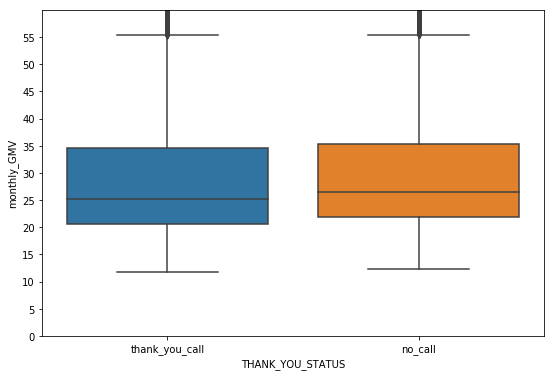

In [17]:
fig, ax = plt.subplots(figsize=(9,6))
sns.boxplot(x="THANK_YOU_STATUS", y="monthly_GMV", data=data)
ax.set_ylim(0,60)
ax.set_yticks(np.arange(0,60,5))
plt.show()

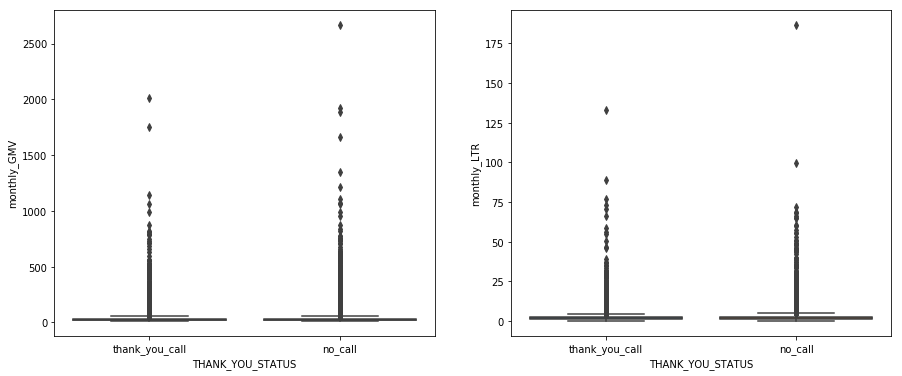

In [18]:
fig,ax = plt.subplots(1,2,figsize=(15,6))
sns.boxplot(x="THANK_YOU_STATUS", y="monthly_GMV", data=data, ax=ax[0])
sns.boxplot(x="THANK_YOU_STATUS", y="monthly_LTR", data=data, ax=ax[1])

Again not much difference in the monthly column values by simple visual analysis (distributions are slightly different but that is expected in practice)

### Statistical hypothesis testing

In [19]:
#two sample independent t-test (without resampling data)
import scipy.stats as ss
print(ss.ttest_ind(thank_you_status_yes.monthly_LTR,thank_you_status_no.monthly_LTR))
print(ss.ttest_ind(thank_you_status_yes.monthly_GMV,thank_you_status_no.monthly_GMV))
print(ss.ttest_ind(thank_you_status_yes.monthly_BOOKINGS,thank_you_status_no.monthly_BOOKINGS))

Ttest_indResult(statistic=-1.81379537907387, pvalue=0.06972184594879503)
Ttest_indResult(statistic=0.37709295684080724, pvalue=0.7061078936273852)
Ttest_indResult(statistic=-1.1182445277536621, pvalue=0.26347387975038244)


In [20]:
#two sample independent t-test (with resampling data)
import sklearn.utils as sk
boot_ltr_yes = sk.resample(thank_you_status_yes.monthly_LTR, n_samples=8287, random_state=1)
boot_ltr_no = sk.resample(thank_you_status_no.monthly_LTR, n_samples=8287, random_state=1)

boot_GMV_yes = sk.resample(thank_you_status_yes.monthly_GMV, replace=False, random_state=1)
boot_GMV_no = sk.resample(thank_you_status_no.monthly_GMV, replace=False, random_state=1)

In [21]:
print(ss.ttest_ind(boot_ltr_yes,boot_ltr_no))
print(ss.ttest_ind(boot_GMV_yes,boot_GMV_no))

Ttest_indResult(statistic=-0.6611251365865555, pvalue=0.5085412571373449)
Ttest_indResult(statistic=0.37709295684079097, pvalue=0.7061078936273972)


Both t-tests fail to reject the null hypothesis at 5% confidence level. However, normality isnt followed. So try non-parametric tests.

In [22]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(boot_ltr_yes, boot_ltr_no)
print('LTR statistics=%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(boot_GMV_yes, boot_GMV_no)
print('GMV statistics=%.3f, p=%.3f' % (stat, p))

LTR statistics=31683790.000, p=0.000
GMV statistics=59025807.500, p=0.000


Mann whitney U test rejects the null hypothesis on resampled data. Thus, one can conclude that when sampling an observation from each group, the control group has a higher than 50% chance to have higher monthly LTR,GMV as compared to that of the treatment group.